# Processing multiple interferograms with ISCE

In [1]:
# Import required packages
import logging
log = logging.getLogger()
log.setLevel(logging.WARN)
import os
import getpass
import asf_search as asf
import isce
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2022-10-02 20:50:29,654 - matplotlib - DEBUG - matplotlib data path: /home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/matplotlib/mpl-data
2022-10-02 20:50:29,660 - matplotlib - DEBUG - CONFIGDIR=/home/jovyan/.config/matplotlib
2022-10-02 20:50:29,663 - matplotlib - DEBUG - interactive is False
2022-10-02 20:50:29,664 - matplotlib - DEBUG - platform is linux
2022-10-02 20:50:29,665 - matplotlib - DEBUG - loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakr

In [ ]:
# Set environment variables so that you can call ISCE from the command line
os.environ['ISCE_HOME'] = os.path.dirname(isce.__file__)
os.environ['ISCE_ROOT'] = os.path.dirname(os.environ['ISCE_HOME'])
os.environ['PATH']+='{ISCE_HOME}/bin:{ISCE_HOME}/applications'.format(**os.environ)
print(os.environ['PATH'])

In [ ]:
!which topsApp.py

In [2]:
scene_list = ['S1A_IW_SLC__1SSV_20150807T005405_20150807T005425_007150_009C22_E1FA',
              'S1A_IW_SLC__1SSV_20150831T005407_20150831T005426_007500_00A5B5_1827',
              'S1A_IW_SLC__1SSV_20160801T005409_20160801T005429_012400_01357B_3A69',
              'S1A_IW_SLC__1SDV_20160825T005410_20160825T005444_012750_01412A_9FD6',
              'S1B_IW_SLC__1SDV_20170721T005332_20170721T005359_006579_00B928_CAB5',
              'S1B_IW_SLC__1SDV_20170814T005333_20170814T005400_006929_00C349_C0B0',
              'S1B_IW_SLC__1SDV_20170907T005334_20170907T005401_007279_00CD6E_7850',
              'S1B_IW_SLC__1SDV_20180716T005338_20180716T005405_011829_015C56_7FDC',
              'S1B_IW_SLC__1SDV_20180728T005339_20180728T005406_012004_01619A_018A',
              'S1B_IW_SLC__1SDV_20180809T005339_20180809T005406_012179_0166F4_7E4A',
              'S1B_IW_SLC__1SDV_20180821T005340_20180821T005407_012354_016C68_56B2',
              'S1B_IW_SLC__1SDV_20180902T005341_20180902T005408_012529_0171D0_3DAB',
              'S1B_IW_SLC__1SDV_20180914T005341_20180914T005408_012704_017728_DEC2',
              'S1B_IW_SLC__1SDV_20190723T005345_20190723T005412_017254_02073F_EB6A',
              'S1B_IW_SLC__1SDV_20190804T005345_20190804T005412_017429_020C80_CDA8',
              'S1B_IW_SLC__1SDV_20190816T005346_20190816T005413_017604_0211E1_97D7',
              'S1B_IW_SLC__1SDV_20190828T005347_20190828T005414_017779_021756_1AD2',
              'S1B_IW_SLC__1SDV_20190909T005348_20190909T005415_017954_021CCD_058C',
              'S1B_IW_SLC__1SDV_20200717T005351_20200717T005418_022504_02AB6A_333A',
              'S1B_IW_SLC__1SDV_20200729T005352_20200729T005419_022679_02B0C0_8427',
              'S1B_IW_SLC__1SDV_20200810T005352_20200810T005419_022854_02B621_D8F8',
              'S1B_IW_SLC__1SDV_20200822T005353_20200822T005420_023029_02BB99_67C5',
              'S1B_IW_SLC__1SDV_20200903T005354_20200903T005421_023204_02C10B_ABD8',
              'S1B_IW_SLC__1SDV_20210724T005357_20210724T005424_027929_035525_EE27',
              'S1B_IW_SLC__1SDV_20210805T005358_20210805T005425_028104_035A51_6DFE',
              'S1B_IW_SLC__1SDV_20210817T005358_20210817T005425_028279_035FC5_317B',
              'S1B_IW_SLC__1SDV_20210829T005359_20210829T005426_028454_036537_C5DB',
              'S1B_IW_SLC__1SDV_20210910T005400_20210910T005427_028629_036AB0_CC77'
             ]

In [3]:
def select_pairs(scene_list, max_temp_bline):
    scene_dates = {}
    for scene in scene_list:
        date = scene[17:25]
        scene_dates[date] = scene
        
    pair_dict = {}
    pair_scenes = []
    for date1 in scene_dates:
        for date2 in scene_dates:
            if datetime.strptime(date2, '%Y%m%d')-datetime.strptime(date1, '%Y%m%d') < timedelta(days=max_temp_bline) and not date1 >= date2 :
                pair_dict[f'{date1}-{date2}'] = [scene_dates[date1], scene_dates[date2]]
                pair_scenes.append(scene_dates[date1])
                pair_scenes.append(scene_dates[date2])
    pair_scenes = [*set(pair_scenes)]
    
    print(f'number of pairs: {len(pair_dict)}')
    
    return pair_dict, pair_scenes

In [4]:
pair_dict, pair_scenes = select_pairs(scene_list, 40)

number of pairs: 43


In [5]:
proc_path = '/home/jovyan/rmnp_landslide/proc'
dem_name = 'usgs_10m.dem.wgs84'

In [ ]:
for pair in pair_dict:
    pair_path = f'{proc_path}/{pair}'
    if not os.path.exists(pair_path):
                          os.makedirs(pair_path)
    !cp '{proc_path}/{dem_name}.xml' '{pair_path}/{dem_name}.xml'
    !cp '{proc_path}/{dem_name}' '{pair_path}/{dem_name}'

## Download all SLCs

In [ ]:
EARTHDATA_LOGIN = "qbrencherUW"
EARTHDATA_PASSWORD = getpass.getpass()

In [ ]:
# Change to SLC directory
os.chdir(f'{proc_path}/slc')

logging.getLogger("urllib3").setLevel(logging.WARNING)

results = asf.granule_search(pair_scenes)
session = asf.ASFSession().auth_with_creds(EARTHDATA_LOGIN, EARTHDATA_PASSWORD)
results.download(path=f'{proc_path}/slc', processes=2, session=session)

## Download orbital files

In [ ]:
os.chdir(f'{proc_path}/orbital')

In [ ]:
%%bash

wget -nc https://raw.githubusercontent.com/isce-framework/isce2/main/contrib/stack/topsStack/fetchOrbit.py
chmod +x fetchOrbit.py

In [ ]:
# grab orbital files with fetchOrbit.py
for scene in pair_scenes:
    os.system(f'./fetchOrbit.py -i {scene}')

## Write input files

In [ ]:
for pair in pair_dict:
    os.chdir(f'{proc_path}/{pair}')
    
    reference = pair_dict[pair][0]
    secondary = pair_dict[pair][1]
    
    with open('topsApp.xml', 'w') as f:
        f.write(f"""<?xml version="1.0" encoding="UTF-8"?>
    <topsApp>
      <component name="topsinsar">
        <property name="Sensor name">SENTINEL1</property>
        <component name="reference">
            <property name="orbit directory">{proc_path}/orbital</property>
            <property name="output directory">reference</property>
            <property name="safe">{proc_path}/slc/{reference}.zip</property>
        </component>
        <component name="secondary">
            <property name="orbit directory">{proc_path}/orbital</property>
            <property name="output directory">secondary</property>
            <property name="safe">{proc_path}/slc/{secondary}.zip</property>
        </component>
        <property name="demfilename">{proc_path}/usgs_10m.dem.wgs84</property>
        <property name="useGPU">True</property>
        <property name="range looks">6</property>
        <property name="azimuth looks">1</property>
        <property name="swaths">[1]</property>
        <property name="region of interest">[40.295, 40.310, -105.69, -105.67]</property>
        <property name="do esd">False</property>
        <property name="do ionospherecorrection">False</property>
        <property name="do unwrap">True</property>
        <property name="unwrapper name">snaphu_mcf</property>
        <property name="do denseoffsets">False</property>
        <property name="geocode demfilename">{proc_path}/usgs_10m.dem.wgs84</property>
        <property name="geocode list">['merged/topophase.cor', 'merged/filt_topophase.unw', 'merged/filt_topophase.flat']</property>
      </component>
    </topsApp>""")

## TopsApp processing

In [ ]:
%%time

for pair in pair_dict:
    os.chdir(f'{proc_path}/{pair}')
    
    !topsApp.py --start=preprocess --end=geocode

## Filter and stack interferograms
### Load igrams into xarray

In [6]:
import xarray as xr
import rasterio as rio
import rioxarray

2022-10-02 20:50:47,681 - numcodecs - DEBUG - Registering codec 'zlib'
2022-10-02 20:50:47,682 - numcodecs - DEBUG - Registering codec 'gzip'
2022-10-02 20:50:47,684 - numcodecs - DEBUG - Registering codec 'bz2'
2022-10-02 20:50:47,685 - numcodecs - DEBUG - Registering codec 'lzma'
2022-10-02 20:50:47,688 - numcodecs - DEBUG - Registering codec 'blosc'
2022-10-02 20:50:47,689 - numcodecs - DEBUG - Registering codec 'zstd'
2022-10-02 20:50:47,691 - numcodecs - DEBUG - Registering codec 'lz4'
2022-10-02 20:50:47,692 - numcodecs - DEBUG - Registering codec 'astype'
2022-10-02 20:50:47,693 - numcodecs - DEBUG - Registering codec 'delta'
2022-10-02 20:50:47,694 - numcodecs - DEBUG - Registering codec 'quantize'
2022-10-02 20:50:47,696 - numcodecs - DEBUG - Registering codec 'fixedscaleoffset'
2022-10-02 20:50:47,697 - numcodecs - DEBUG - Registering codec 'packbits'
2022-10-02 20:50:47,698 - numcodecs - DEBUG - Registering codec 'categorize'
2022-10-02 20:50:47,699 - numcodecs - DEBUG - Reg

In [7]:
# functions to load interferogram tifs to xarray

def xr_read_vrt(vrt_file_path, masked=True):

    da = rioxarray.open_rasterio(vrt_file_path, masked=True)

    # Extract phase and assign as variable in xr.Dataset()
    ds = xr.Dataset()
    da_phase = da.sel(band=2)
    da_phase.name = 'unw_phase'
    ds[da_phase.name] = da_phase

    # Preserve top-level attributes and extract single value from value iterables e.g. (1,) --> 1
    ds.attrs = da.attrs
    for key, value in ds.attrs.items():
        try:
            if len(value) == 1:
                ds.attrs[key] = value[0]
        except TypeError:
            pass
    
    # crop to roi
    ds = ds.rio.clip_box(minx=-105.69, miny=40.29, maxx=-105.66, maxy=40.31) 

    return ds

In [8]:
igram_dss = []
#coh_dss = []
igram_name = 'merged/filt_topophase.unw.geo.vrt'
#coh_name = 'merged/topophase.cor.geo.vrt'

for pair in pair_dict:
    igram_src = xr_read_vrt(f'{proc_path}/{pair}/{igram_name}')
    igram_src = igram_src.assign_coords({"dates": pair})
    igram_src = igram_src.expand_dims("dates")
    
    igram_dss.append(igram_src)
                            
    #coh_src = xr_read_vrt(f'{proc_path}/{pair}/{coh_name}')
    #coh_src = coh_src.assign_coords({"dates": pair})
    #coh_src = coh_src.expand_dims("dates")
    #coh_dss.append(coh_src)

2022-10-02 20:50:50,873 - rasterio.env - DEBUG - Entering env context: <rasterio.env.Env object at 0x7fbdc1f350a0>
2022-10-02 20:50:50,874 - rasterio.env - DEBUG - Starting outermost env
2022-10-02 20:50:50,876 - rasterio.env - DEBUG - No GDAL environment exists
2022-10-02 20:50:50,876 - rasterio.env - DEBUG - New GDAL environment <rasterio._env.GDALEnv object at 0x7fbdc747e3d0> created
2022-10-02 20:50:50,878 - rasterio._filepath - DEBUG - Installing FilePath filesystem handler plugin...
2022-10-02 20:50:50,878 - rasterio._env - DEBUG - GDAL_DATA found in environment.
2022-10-02 20:50:50,880 - rasterio._env - DEBUG - PROJ_LIB found in environment.
2022-10-02 20:50:50,882 - rasterio._env - DEBUG - Started GDALEnv: self=<rasterio._env.GDALEnv object at 0x7fbdc747e3d0>.
2022-10-02 20:50:50,883 - rasterio.env - DEBUG - Entered env context: <rasterio.env.Env object at 0x7fbdc1f350a0>
2022-10-02 20:50:50,884 - rasterio._base - DEBUG - Sharing flag: 0
2022-10-02 20:50:50,887 - rasterio._base

In [9]:
# standardize coordinates before concat
igram_dss_standard = [igram_dss[0]]

x_reference = igram_dss[0]['x'].values
y_reference = igram_dss[0]['y'].values

for ds in igram_dss[1:]:
    ds = ds.assign_coords({'x': ('x', x_reference),
                      'y': ('y', y_reference)})
    igram_dss_standard.append(ds)

igram_ds = xr.concat(igram_dss_standard, dim='dates', combine_attrs="no_conflicts") #create dataset

In [10]:
igram_ds

<xarray.Dataset>
Dimensions:      (x: 325, y: 217, dates: 43)
Coordinates:
    band         int64 2
  * x            (x) float64 -105.7 -105.7 -105.7 ... -105.7 -105.7 -105.7
  * y            (y) float64 40.31 40.31 40.31 40.31 ... 40.29 40.29 40.29 40.29
    spatial_ref  int64 0
  * dates        (dates) <U17 '20150807-20150831' ... '20210829-20210910'
Data variables:
    unw_phase    (dates, y, x) float32 -6.854 -6.854 -6.854 ... -1.44 -1.104
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

### Change reference points

In [11]:
# function to find value of new reference point in each time slice and subtract it from data array
rref_list = []

def change_ref(ds, lat, lon):
    reref = ds.copy(deep=True)
    for i in range(ds.sizes['dates']):
        # get value from grid
        rref_list.append(float(ds.isel(dates=i).unw_phase.sel(x=lon, y=lat, method='nearest').values))
    reref['unw_phase'] = ds['unw_phase'] - xr.DataArray(rref_list, dims='dates')
    return reref 

In [12]:
igram_ds = change_ref(igram_ds, 40.302247, -105.672370)

2022-10-02 20:50:59,308 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-10-02 20:50:59,310 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-10-02 20:50:59,313 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-10-02 20:50:59,315 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-10-02 20:50:59,316 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', var

2022-10-02 20:50:59,688 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-10-02 20:50:59,690 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-10-02 20:50:59,690 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
2022-10-02 20:50:59,691 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/matplotlib/mpl-data/font

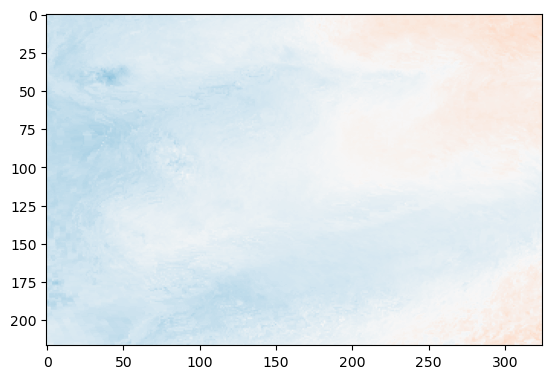

In [13]:
f, ax = plt.subplots()
ax.imshow(igram_ds['unw_phase'].median(dim='dates'), cmap='RdBu', vmin=-5, vmax=5)

### Convert to velocities in m/yr

In [117]:
delta_list = []
for date in igram_ds['dates'].values:
    delta_list.append((datetime.strptime(date[9:17], '%Y%m%d')-datetime.strptime(date[0:8], '%Y%m%d')).days)
    
igram_ds = igram_ds.assign_coords({'timedelta':('timedelta', delta_list)})

veloc = (((igram_ds['unw_phase']*0.05546576/12.5663706)/igram_ds['timedelta'])*365.24)[0].values
igram_ds['veloc'] = (('y', 'x', 'dates'), veloc.data)
igram_ds = igram_ds.drop_dims('timedelta')

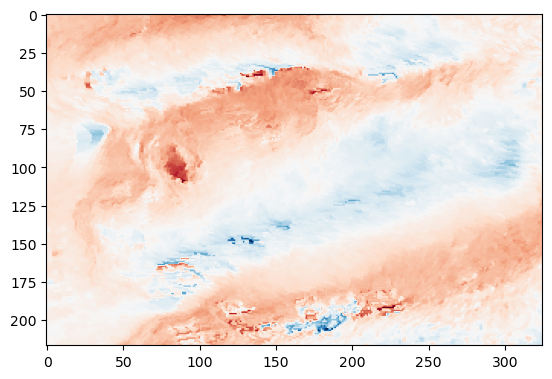

In [120]:
f, ax = plt.subplots()
ax.imshow(igram_ds['veloc'].median(dim="dates"), cmap='RdBu', vmin=-0.3, vmax=0.3) 

### filter and stack